# Predicting First Snow Dates of the Season using K-Nearest Neighbors Regression
Here's a fun little application of Scikit-learn K-Nearest Neighbors regression modeling. We'll use NOAA's GHCND dataset (https://www.ncei.noaa.gov/pub/data/ghcn/daily/by_year/), just like in my "Snow-Days" visualization project here.<br><br>
We'll use the Latitude, Longitude, and date of first observed snow (converted to the integer number of days relative to September 1st) for all continental U.S. weather stations from 1980 to 2020. The output is a heatmap of the predicted first date of snow across the entire continent, where the KNN model predicts the date based off the latitude and longitude, and is trained by the prepped GHCND dataset.<br><br>
Some interesting things to play around with the in the future could include using the elevation of the station when training the model or the season year. The latter would allow you to model changes over time, not just over geography.

## Loading Prepared Data from a CSV

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import sklearn
import datetime
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

# Path to the .shp file used for generating the USA map
states_shapefile_path = r"data\shapefile-data\usa-states-census-2014.shp"
# GZIP CSV consisting of station first-snow-dates.
first_snow_dates_filepath = "data/first-snow-dates-per-station_1980-2020.csv.gz"

In [6]:
# Read CSV data into a dataframe
masterdf = pd.read_csv(r"data\first-snow-dates-per-station_1980-2020.csv.gz")
masterdf.sample(5)

,latitude,longitude,elevation,date,season_year,days
261107,41.587000,-109.216200,1916.9,2016-11-17,2016,77
119114,35.277400,-102.463300,1218.6,2002-12-04,2002,94
47985,46.638300,-113.176100,1219.2,1988-11-10,1988,70
293563,40.379850,-86.866500,196.9,2019-11-01,2019,61
282013,44.304563,-70.002747,108.8,2018-11-10,2018,70


Let's plot ALL points on the same scatterplot, heatmapped by their first snow day

## Defining Display & Mapping Functions

In [24]:
#Read the geopandas shape file for continental US states
states = gpd.read_file(states_shapefile_path)

def generate_geodataframe(input_df):    
    '''
    Given an input dataframe with `latitude`, `longitude`, `elevation`,
        `date` of first snow observed at that site (YYYY-MM-DD), the winter season
        year `year`, and `days` (integer days between `date` and September 1st of that winter),
    Generate a Geodataframe consisting of 2D point geometries. Elevation is not used, but provided
        for future work.
    '''
    #defined coordinate reference system. Use the same as the states shapefile.
    crs='epsg:4326'
    #define a geometry consisting of Points, to use as the GDF geometry
    geometry=[Point(longlat_tuple) for longlat_tuple in zip(input_df['longitude'], input_df['latitude'])]
    #create the GDF using the data and the geometry
    geoDF = gpd.GeoDataFrame(input_df[['date', 'season_year', "days"]], crs=crs, geometry=geometry)
    return geoDF

def points_per_day(input_df, month=None, day=1, reference_month=9, crs="epsg:4326"):
    ''' 
    Provide an dataframe (to the specifications 
        of `generate_geodataframe`, target month, and optional day, and
    Return a geodataframe of all sites whose first snow day occurs before that day of the season.
        Assumes a Sep 1st start.
        If month is not provided, all data is used
    '''
    if month is None:
        selected_data = input_df
    elif month < reference_month:
        #Account for the new year if the target month occurs before the reference month 
        selected_data = input_df[input_df.date < pd.to_datetime({"year":input_df.season_year + 1, "month":month, "day":day})]
    else:
        selected_data = input_df[input_df.date < pd.to_datetime({"year":input_df.season_year, "month":month, "day":day})]
    #print(selected_data)
    geometry=[Point(longlat_tuple) for longlat_tuple in zip(selected_data['longitude'], selected_data['latitude'])]
    selectGeoDF = gpd.GeoDataFrame(selected_data[['date', 'season_year', "days"]], crs=crs, geometry=geometry)
    return selectGeoDF

def convert_days_to_date(days, reference_month=9, reference_day=1):
    """
    Given an integer `days` value, assumed to be the number of days since September 1st (ignore leap years),
    Calculate the month and day associated with that difference.
    Return a pandas datetime object
    """
    #Let's use an arbitrary, non-leap reference year
    reference_year = 2022
    delta = datetime.timedelta(days=days)
    reference = datetime.datetime(reference_year, reference_month, reference_day)
    full_date = reference + delta
    return full_date

def generate_map(pointsGDF, month=None, day=1, reference_month=9, crs="epsg:4326", title_text="Date of First Snow"):
    """
    Generate a heatmap of points 
    """
    continentalUS = states.boundary.plot(figsize=(12,9), color='grey', linewidth=1)
    plt.title(title_text, fontsize=24)
    pointsGDF.plot(ax=continentalUS, markersize=8, column=pointsGDF.days,\
                  cmap="viridis", alpha = 0.5, legend=True,\
                  legend_kwds={"label": f"Days since {reference_month}/1", \
                               "orientation": "horizontal",
                              "ticks":[i*30 for i in range(0,360) if i < pointsGDF.days.max()]})
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

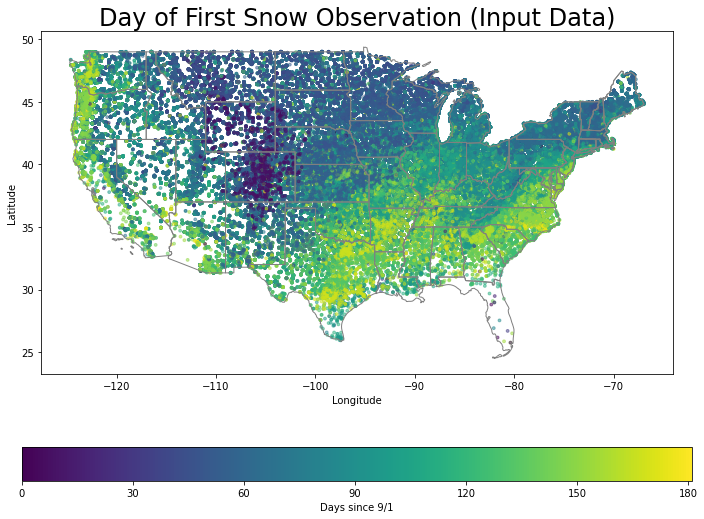

In [25]:
pointsGDF = points_per_day(masterdf)
generate_map(pointsGDF, title_text = "Day of First Snow Observation (Input Data)")

## Generate and Train KNN Regression Model
Now let's use a K-Nearest Neighbors regression model to predict the integer day of first snow based on latitude and longistude

In [10]:
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X = masterdf[["longitude", "latitude"]]
print(len(X))
y = masterdf.days

scaler = StandardScaler()
X_transformed = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, random_state = 0)

neighbors = 40
knn_reg = KNeighborsRegressor(n_neighbors = neighbors).fit(X_train, y_train)
score = knn_reg.score(X_test, y_test)
print("R-squared score with {} neighbors: {}".format(neighbors, score))

317872
R-squared score with 40 neighbors: 0.4541980303666745


In [11]:
def create_point_gdf(lon_array, lat_array, crs="epsg:4326"):
    coord_list = []
    for lon in lon_array:
        for lat in lat_array:
            coord_list.append((lon, lat))
    geom = [Point(lonlat_tuple) for lonlat_tuple in coord_list]
    gdf = gpd.GeoDataFrame(coord_list, columns=["longitude", "latitude"], crs=crs, geometry=geom)
    return gdf

lon_arr = np.linspace(-130, -60, 1000)
lat_arr = np.linspace(22, 50, 1000)
uniform_points = create_point_gdf(lon_arr, lat_arr)
clipped_points = gpd.clip(uniform_points, states).reset_index(drop=True)

In [12]:
X_scaled = scaler.fit_transform(clipped_points[["longitude", "latitude"]])
y_predict = knn_reg.predict(X_scaled)
output_clipped_points = clipped_points.copy()
output_clipped_points["days"] = y_predict
output_clipped_points.head(7)

,longitude,latitude,geometry,days
0,-124.674675,47.981982,POINT (-124.67467 47.98198),112.725
1,-124.674675,48.010010,POINT (-124.67467 48.01001),113.350
2,-124.674675,48.038038,POINT (-124.67467 48.03804),113.825
3,-124.674675,48.066066,POINT (-124.67467 48.06607),115.425
4,-124.674675,48.094094,POINT (-124.67467 48.09409),115.425
5,-124.674675,48.122122,POINT (-124.67467 48.12212),115.150
6,-124.674675,48.150150,POINT (-124.67467 48.15015),95.250


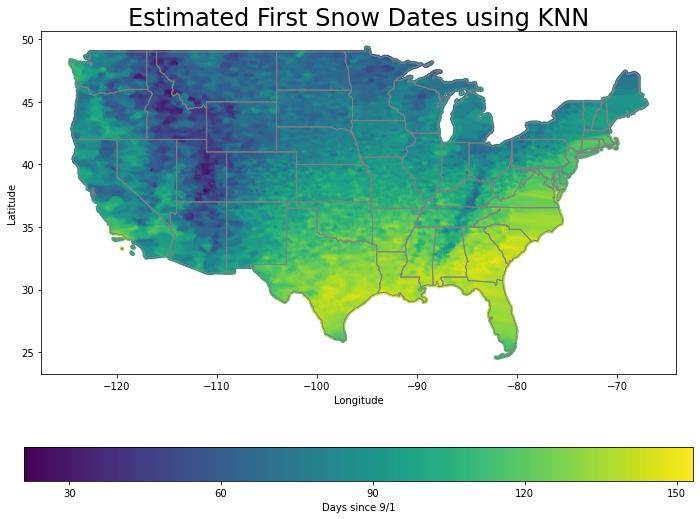

In [26]:
generate_map(output_clipped_points, title_text="Estimated First Snow Dates using KNN")